In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.plots as mpplots
from siphon.catalog import TDSCatalog
import numpy as np

from io import StringIO
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays, units
from matplotlib.patheffects import withStroke
from metpy.cbook import get_test_data
import pandas as pd

In [2]:
dt = datetime.utcnow() - timedelta(hours=1)

In [3]:
rtma_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml')
rtma_data = rtma_cat.datasets['Full Collection Dataset'].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf()

In [4]:
pres = rtma_data['Pressure_Analysis_surface'].metpy.sel(time=dt, method='nearest').squeeze()
temp = rtma_data['Temperature_Analysis_height_above_ground'].metpy.sel(time=dt, method='nearest').squeeze()
dewp = rtma_data['Dewpoint_temperature_Analysis_height_above_ground'].metpy.sel(time=dt, method='nearest').squeeze()

In [5]:
thetae = mpcalc.equivalent_potential_temperature(pres, temp, dewp)
thetae = mpcalc.smooth_gaussian(thetae, n=8)

In [6]:
plot_proj = thetae.metpy.cartopy_crs

## METAR

In [7]:
airports_df = pd.read_csv(get_test_data('airport-codes.csv'))
airports_df = airports_df[(airports_df['type'] == 'large_airport') | (airports_df['type'] == 'medium_airport')]

metar_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')
metar_file = metar_cat.datasets.filter_time_nearest(dt).remote_open()
metar_text = StringIO(metar_file.read().decode('ascii'))
sfc_data = parse_metar_file(metar_text, year=dt.year, month=dt.month)
sfc_units = sfc_data.units
sfc_units

sfc_data = sfc_data[sfc_data['station_id'].isin(airports_df['ident'])]

sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)
sfc_data['u'], sfc_data['v'] = mpcalc.wind_components(sfc_data['wind_speed'], sfc_data['wind_direction'])

locs = plot_proj.transform_points(ccrs.PlateCarree(), sfc_data['longitude'].m, sfc_data['latitude'].m)

sfc_data_mask = mpcalc.reduce_point_density(locs[:, :2], 90000)

ValueError: invalid literal for int() with base 10: '10SM'

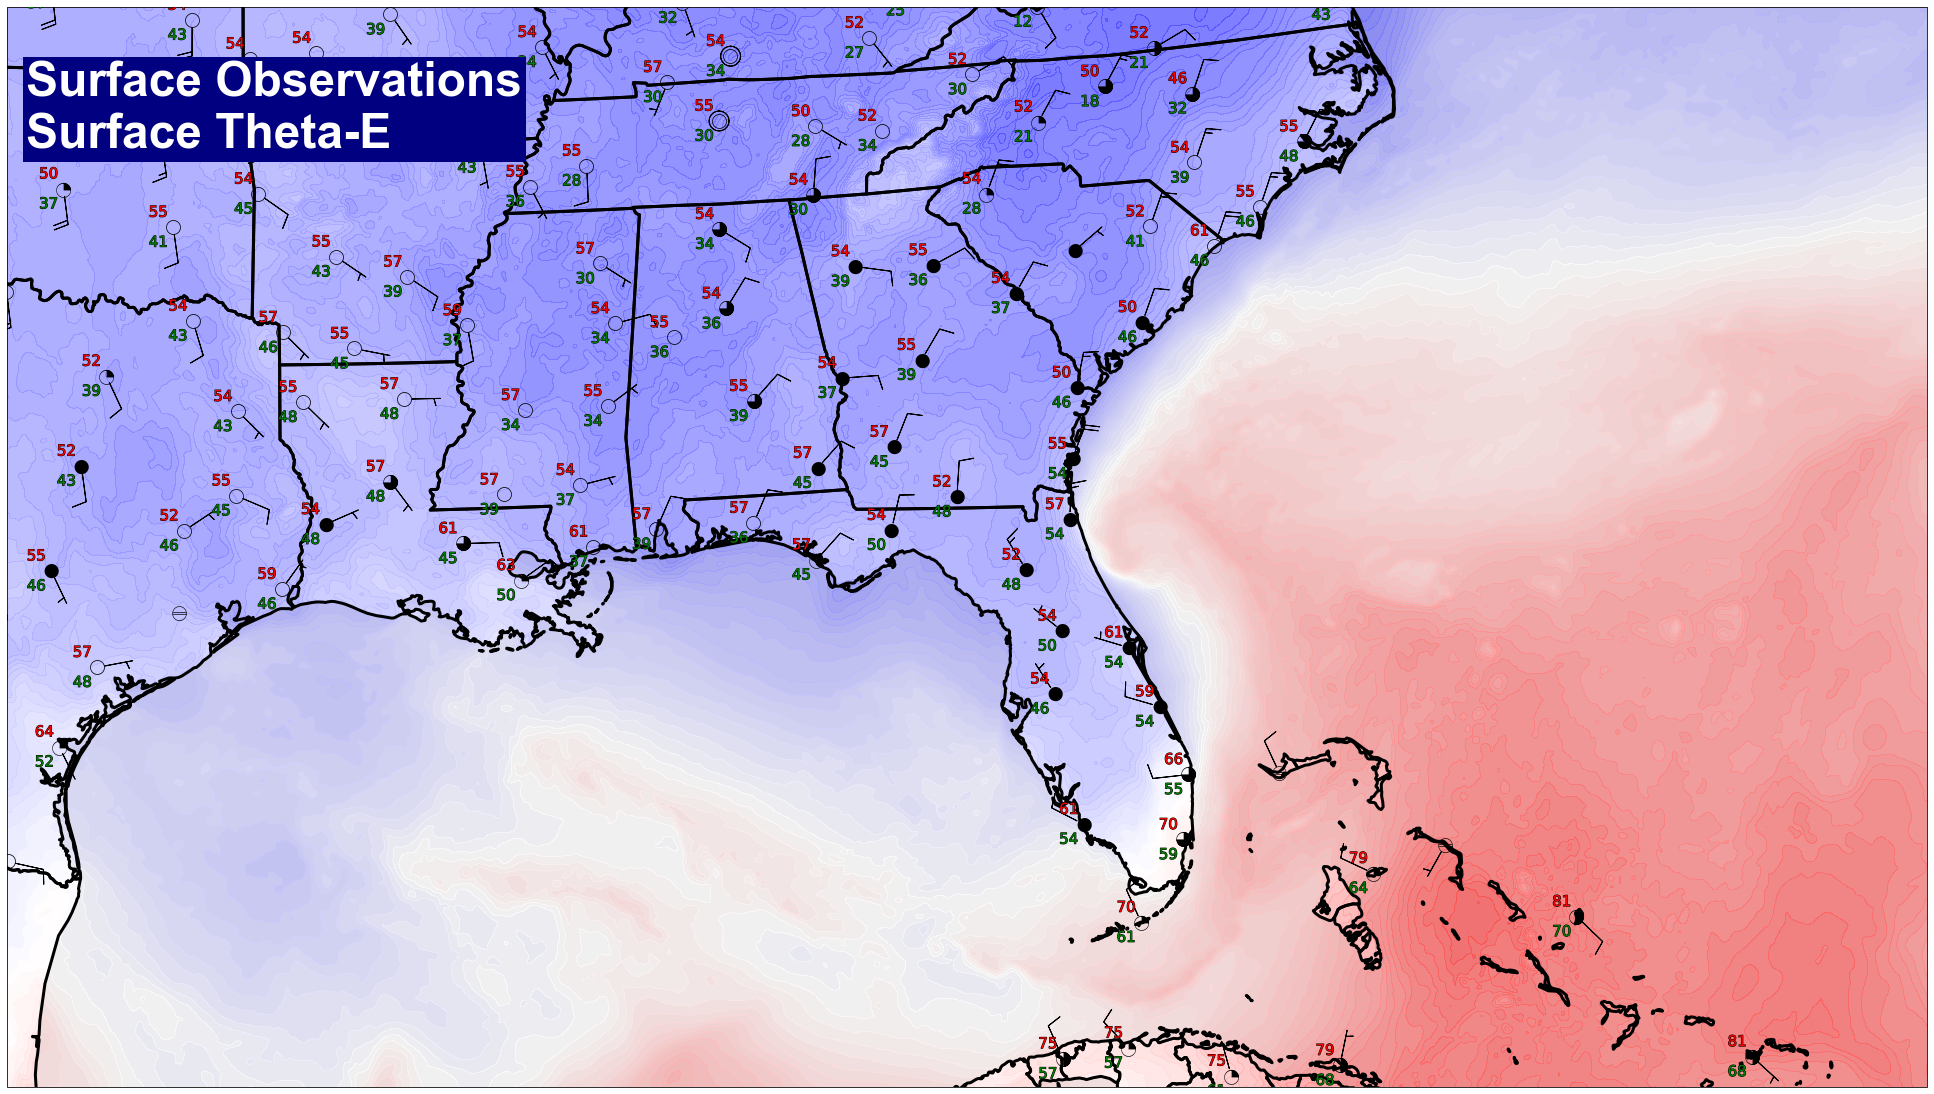

In [45]:
fig = plt.figure(figsize=(1920/72, 1080/72))
#ax = fig.add_subplot(1, 1, 1, projection=plot_proj)
ax = fig.add_axes([0, 0, 1, 1], projection=plot_proj)
#ax.set_extent((-122, -70, 25, 50), crs=ccrs.PlateCarree())
ax.set_extent([-89, -78, 23, 37], crs=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.00)
ax.set_adjustable('datalim')

# Display Banner
plt.text(0.01, 0.95, s='Surface Observations\nSurface Theta-E',
         fontname='Arial', fontsize=48, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
         transform=ax.transAxes, zorder=11, va='top')

# ax.contourf(temp.metpy.x, temp.metpy.y, temp - 273.15,
#             transform=temp.metpy.cartopy_crs,
#             levels=np.arange(-30, 40, 4), cmap='coolwarm')

ax.contourf(thetae.metpy.x, thetae.metpy.y, thetae,
            levels=np.arange(240, 400, 1), cmap=plt.cm.seismic, alpha=0.7,
            transform=thetae.metpy.cartopy_crs)

# METARS
stn = mpplots.StationPlot(ax, sfc_data['longitude'][sfc_data_mask].m, sfc_data['latitude'][sfc_data_mask].m,
                          transform=ccrs.PlateCarree(), fontsize=15, zorder=10, clip_on=True)

stn.plot_parameter('NW', sfc_data['air_temperature'][sfc_data_mask].to('degF'), color='red',
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_parameter('SW', sfc_data['dew_point_temperature'][sfc_data_mask].to('degF'), color='green',
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_symbol('C', sfc_data['cloud_coverage'][sfc_data_mask], mpplots.sky_cover)
stn.plot_barb(sfc_data['u'][sfc_data_mask], sfc_data['v'][sfc_data_mask])

plt.savefig(f'thetae_station-plot.png', dpi=72)